#**Research Question**


How can we leverage historical taxi trip data to forecast the demand for taxis at different locations and times of day using time series analysis and machine learning models? This could help optimize taxi fleet management and resource allocation.


## **Loading Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix


# 1) Load file

In [ ]:
df = pd.read_parquet("/content/yellow_tripdata_2022-01.parquet")

# 2) Exploring The Data


In [ ]:
#First we can check the main statistics and datatypes of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [ ]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,2.463931e+06,2463931,2463931,2.392428e+06,2.463931e+06,2.392428e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.463931e+06,2.392428e+06,2.392428e+06
mean,1.707819e+00,2022-01-17 01:19:51.689724,2022-01-17 01:34:04.421902,1.389453e+00,5.372751e+00,1.415507e+00,1.660768e+02,1.635807e+02,1.194449e+00,1.294648e+01,1.006710e+00,4.914539e-01,2.385696e+00,3.749773e-01,2.967234e-01,1.916937e+01,2.282322e+00,8.249935e-02
min,1.000000e+00,2008-12-31 22:23:09,2008-12-31 23:06:56,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-4.800000e+02,-4.500000e+00,-5.000000e-01,-1.252200e+02,-3.140000e+01,-3.000000e-01,-4.803000e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2022-01-09 15:37:41,2022-01-09 15:50:50.500000,1.000000e+00,1.040000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,7.200000e-01,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2022-01-17 12:11:45,2022-01-17 12:23:49,1.000000e+00,1.740000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.469000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2022-01-24 13:49:37.500000,2022-01-24 14:02:51,1.000000e+00,3.130000e+00,1.000000e+00,2.340000e+02,2.360000e+02,1.000000e+00,1.400000e+01,2.500000e+00,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,2.002000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2022-05-18 20:41:57,2022-05-18 20:47:45,9.000000e+00,3.061593e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.010923e+05,3.350000e+01,1.659000e+01,8.888800e+02,1.933000e+02,3.000000e-01,4.010956e+05,2.500000e+00,1.250000e+00
std,5.021375e-01,NaN,NaN,9.829686e-01,5.478714e+02,5.917573e+00,6.546806e+01,7.079016e+01,5.001778e-01,2.558149e+02,1.236226e+00,8.291560e-02,2.830698e+00,1.680538e+00,4.374741e-02,2.559641e+02,7.432040e-01,3.125554e-01


#2.1) Analyzing PULocationID and DOLocationID

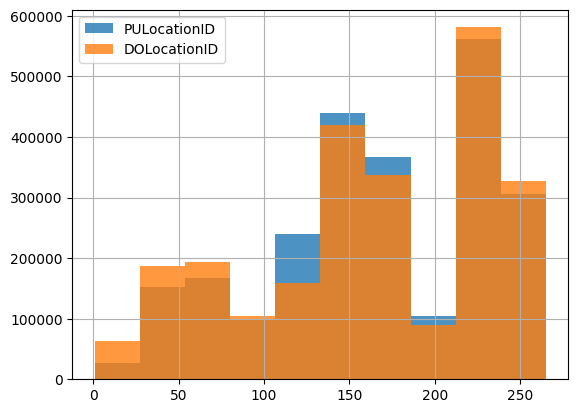

In [ ]:
df["PULocationID"].hist(alpha=0.8, legend=True);
df["DOLocationID"].hist(alpha=0.8, legend=True);

We see that the distrubution for the pick up location (PULocationID), and the drop off location (DOLocationID) is very similar. This indicates that the data is not completely imbalanced, making it easier to feed the data for a ML model.

In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

#2.2) Analyzing the trip_distance

In [ ]:
df["trip_distance"].describe()

count    2.463931e+06
mean     5.372751e+00
std      5.478714e+02
min      0.000000e+00
25%      1.040000e+00
50%      1.740000e+00
75%      3.130000e+00
max      3.061593e+05
Name: trip_distance, dtype: float64

In [ ]:
mask = df["trip_distance"] == df["trip_distance"].max()
df[mask]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2409416,2,2022-01-11 11:48:00,2022-01-11 12:00:00,NaN,306159.28,NaN,None,116,238,0,14.96,0.0,0.5,3.94,0.0,0.3,22.2,NaN,NaN


This seems to be a wrong input on the trip_distance. We can see if it is a missing input by analyzing the taxi trips that had the same Pick Up location and Drop Off location.

<Axes: >

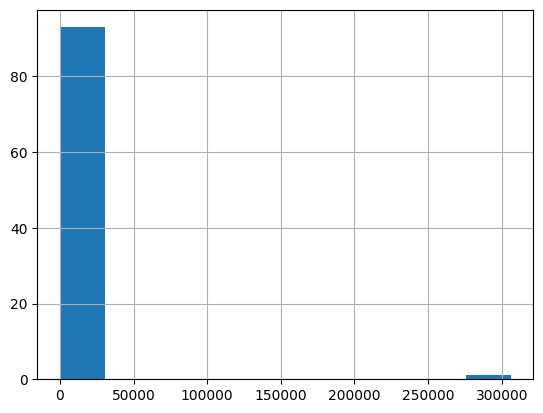

In [ ]:
mask_pu, mask_do = df["PULocationID"] == 116, df["DOLocationID"] == 238
df[mask_pu & mask_do]["trip_distance"].hist()

In [ ]:
df[mask_pu & mask_do]["trip_distance"].value_counts().sort_index()

trip_distance
2.10         2
2.14         1
2.20         2
2.26         1
2.29         1
            ..
3.82         1
3.83         1
3.85         1
6.80         1
306159.28    1
Name: count, Length: 62, dtype: int64

Since there is only one count, we could drop that sample.

#2.3) Analyzing the duration

In [ ]:
df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds()

In [ ]:
df["duration"].describe()

count    2.463931e+06
mean     8.527322e+02
std      2.786718e+03
min     -2.065440e+05
25%      3.790000e+02
50%      6.110000e+02
75%      9.700000e+02
max      5.107910e+05
Name: duration, dtype: float64

In [ ]:
(df["duration"] < 0.).sum()

1353

We see that there are entries which the dropoff datetime happens before the pickup datetime. Thus we will remove those entries.

In [ ]:
df = df.loc[df["duration"] >= 0]

In [ ]:
#Checking for NaN values and dropping them
df.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          70151
trip_distance                0
RatecodeID               70151
store_and_fwd_flag       70151
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     70151
airport_fee              70151
duration                     0
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
duration                 0
dtype: int64

In [ ]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.00,0.3,21.95,2.5,0.0,1069.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.00,0.3,13.30,0.0,0.0,504.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,0.0,0.0,538.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.00,0.3,11.80,2.5,0.0,602.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.00,0.3,30.30,2.5,0.0,2252.0
5,1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.30,1.0,N,138,161,1,33.0,3.0,0.5,13.00,6.55,0.3,56.35,2.5,0.0,1773.0
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.0,0.5,0.5,5.20,0.00,0.3,26.00,2.5,0.0,848.0
7,2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,9.0,0.5,0.5,0.00,0.00,0.3,12.80,2.5,0.0,581.0
8,2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,12.0,0.5,0.5,2.25,0.00,0.3,18.05,2.5,0.0,887.0
9,2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,5.0,0.5,0.5,0.00,0.00,0.3,8.80,2.5,0.0,276.0


#3) Feature Engineering

In [ ]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

#3.1)Visualizations

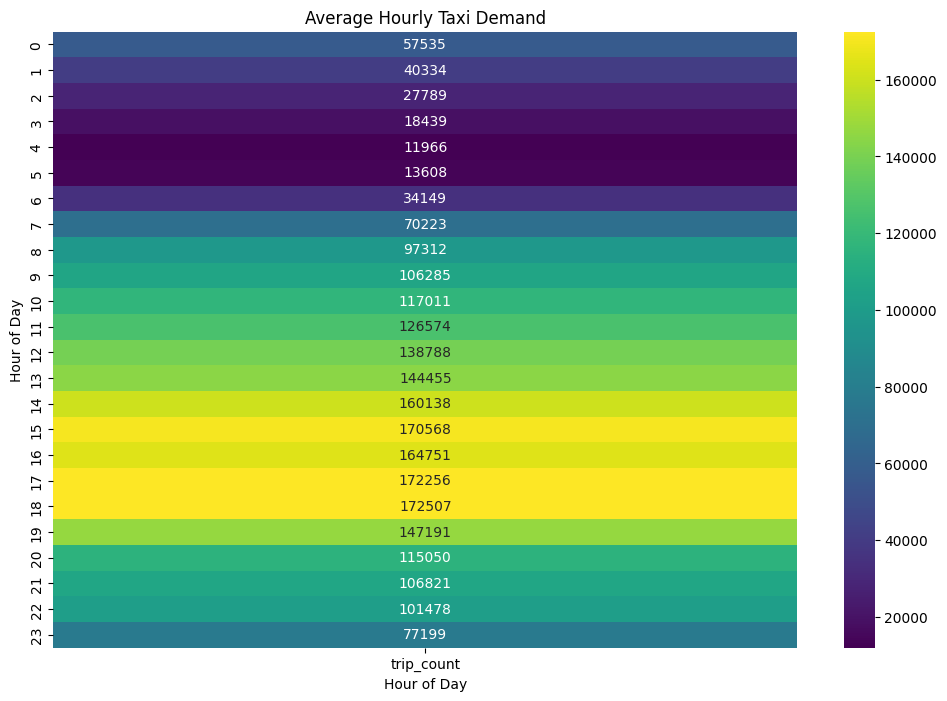

In [ ]:
# Calculate average trip count per hour and day of week
hourly_demand = df.groupby('pickup_hour').size().reset_index(name='trip_count')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_demand.pivot_table(index='pickup_hour', values='trip_count', aggfunc='mean'), cmap='viridis', annot=True, fmt='.0f', cbar=True)
plt.title('Average Hourly Taxi Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Hour of Day')
plt.show()

<ipython-input-60-2002c5920fa6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pickup_locations.index, y=top_pickup_locations.values, palette='viridis')


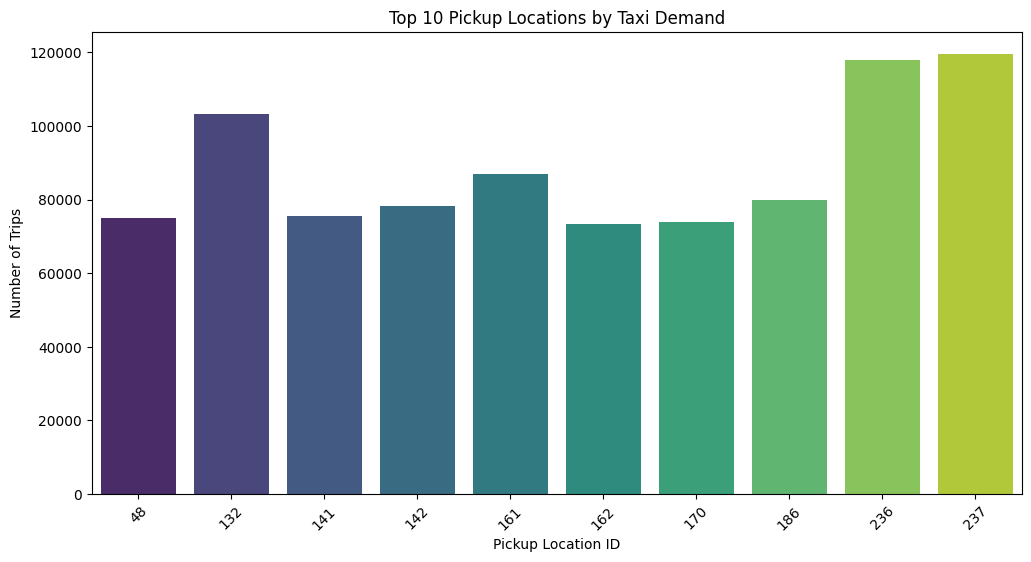

In [ ]:
# Plotting distribution of taxi demand by pickup location
plt.figure(figsize=(12, 6))
top_pickup_locations = df['PULocationID'].value_counts().head(10)
sns.barplot(x=top_pickup_locations.index, y=top_pickup_locations.values, palette='viridis')
plt.title('Top 10 Pickup Locations by Taxi Demand')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

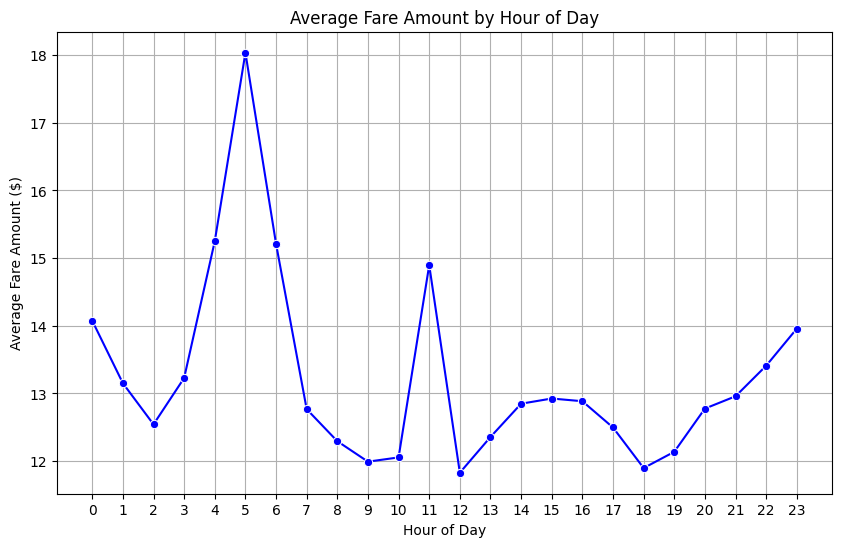

In [ ]:
# Calculate average fare amount by hour of day
average_fare_by_hour = df.groupby('pickup_hour')['fare_amount'].mean()

# Plotting average fare amount by hour of day
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_fare_by_hour.index, y=average_fare_by_hour.values, color='b', marker='o')
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [ ]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration,pickup_hour,pickup_day,pickup_month
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,3.65,0.00,0.3,21.95,2.5,0.0,1069.0,0,5,1
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,4.00,0.00,0.3,13.30,0.0,0.0,504.0,0,5,1
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,1.76,0.00,0.3,10.56,0.0,0.0,538.0,0,5,1
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.00,0.00,0.3,11.80,2.5,0.0,602.0,0,5,1
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,3.00,0.00,0.3,30.30,2.5,0.0,2252.0,0,5,1
5,1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.30,1.0,N,138,161,1,...,13.00,6.55,0.3,56.35,2.5,0.0,1773.0,0,5,1
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,...,5.20,0.00,0.3,26.00,2.5,0.0,848.0,0,5,1
7,2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,...,0.00,0.00,0.3,12.80,2.5,0.0,581.0,0,5,1
8,2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,...,2.25,0.00,0.3,18.05,2.5,0.0,887.0,0,5,1
9,2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,...,0.00,0.00,0.3,8.80,2.5,0.0,276.0,0,5,1


#4.1) Model Building & Evaluation

In [ ]:
# Machine Learning Models
# Prepare features and target variable
df = df.dropna(subset=['passenger_count'])

X = df[['PULocationID','pickup_hour', 'pickup_day', 'pickup_month']] #feature variables
y = df['passenger_count'] #target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_train_score=model.fit(X_train,y_train).score(X_test,y_test)
print("Test accuracy: {:.3f}".format(rf_train_score))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Test accuracy: 0.750
Mean Absolute Error: 0.4327253043976208


In [ ]:
#Adaboost Classifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
ada_score = cross_val_score(ada, X_train, y_train, cv=5)
print("Average cross validation score: {:.3f}".format(ada_score.mean()))
print("Test accuracy: {:.3f}".format(ada.score(X_test, y_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Average cross validation score: 0.733
Test accuracy: 0.709


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Test accuracy
gb_train_score = gb_model.score(X_test, y_test)
print("Test accuracy (Gradient Boosting): {:.3f}".format(gb_train_score))

# Predict on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model
gb_mae = mean_absolute_error(y_test, gb_y_pred)
print("Mean Absolute Error (Gradient Boosting):", gb_mae)



Test accuracy (Gradient Boosting): 0.750
Mean Absolute Error (Gradient Boosting): 0.43285696969190324


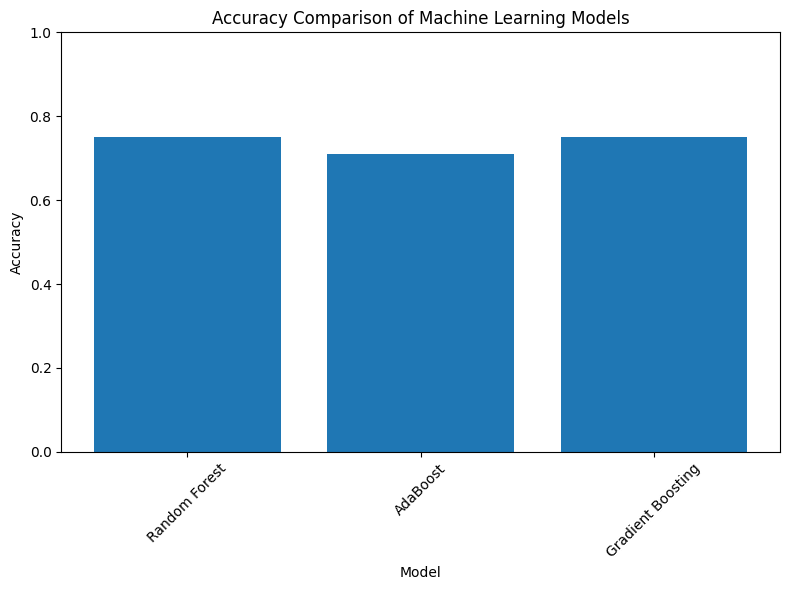

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values
rf_accuracy = rf_train_score
ada_accuracy = ada.score(X_test, y_test)
gb_accuracy = gb_train_score

# Model names
models = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(models, [rf_accuracy, ada_accuracy, gb_accuracy])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1 (for accuracy)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()
plt.show()

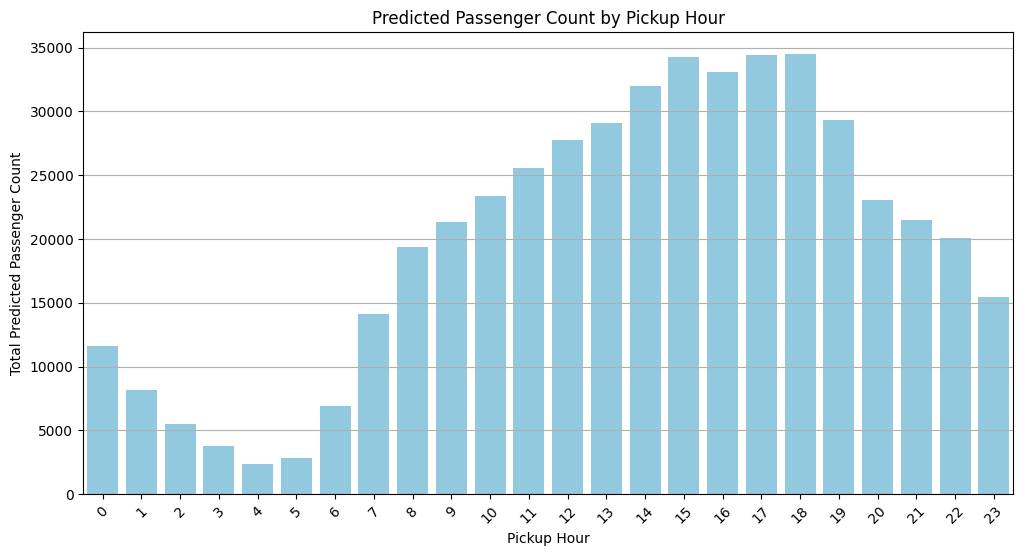

In [ ]:

# Aggregate predicted passenger counts by pickup hour
hourly_pred_counts = pd.DataFrame({'pickup_hour': X_test['pickup_hour'], 'predicted_passenger_count': y_pred})
hourly_pred_counts = hourly_pred_counts.groupby('pickup_hour').sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='pickup_hour', y='predicted_passenger_count', data=hourly_pred_counts, color='skyblue')
plt.title('Predicted Passenger Count by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Total Predicted Passenger Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


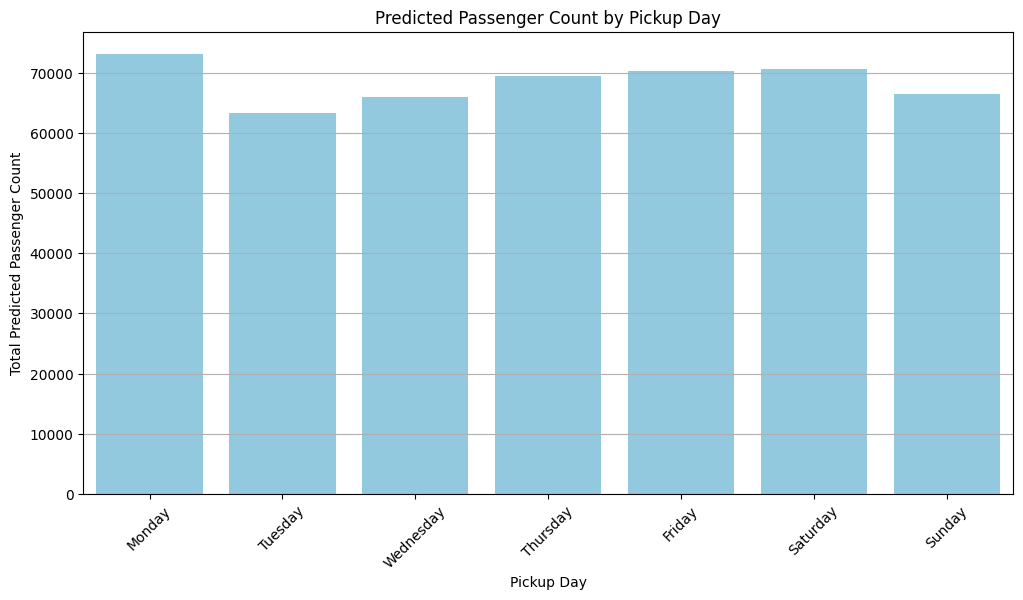

In [ ]:
# Aggregate predicted passenger counts by pickup day
daily_pred_counts = pd.DataFrame({'pickup_day': X_test['pickup_day'], 'predicted_passenger_count': y_pred})
daily_pred_counts = daily_pred_counts.groupby('pickup_day').sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='pickup_day', y='predicted_passenger_count', data=daily_pred_counts, color='skyblue')
plt.title('Predicted Passenger Count by Pickup Day')
plt.xlabel('Pickup Day')
plt.ylabel('Total Predicted Passenger Count')
day_names = [calendar.day_name[i] for i in range(7)]
plt.xticks(ticks=range(7), labels=day_names, rotation=45)
plt.grid(axis='y')
plt.show()


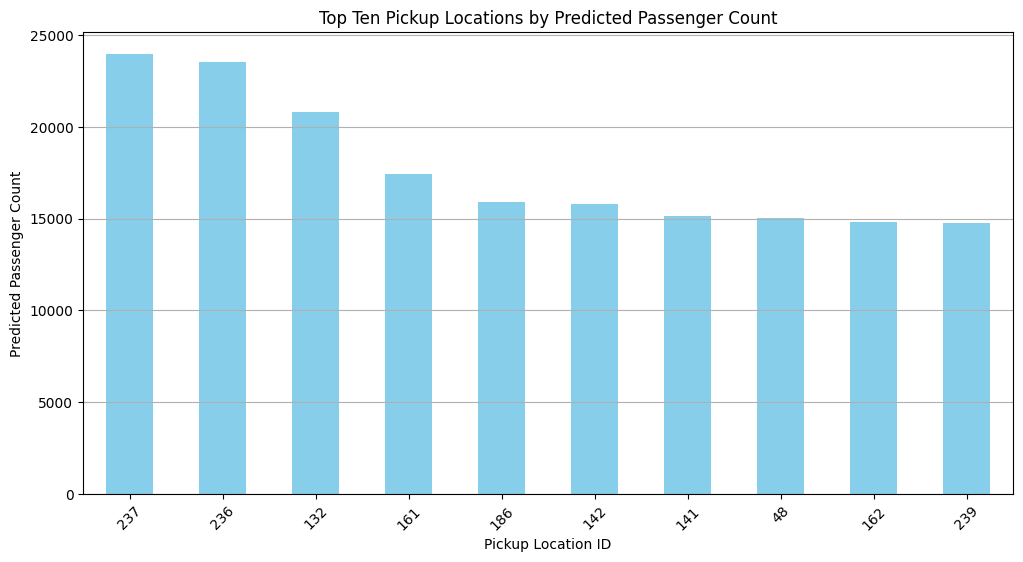

In [ ]:
X_test['predicted_passenger_count'] = y_pred

# Calculate total predicted passenger counts for each pickup location
predicted_pickup_location_passenger_counts = X_test.groupby('PULocationID')['predicted_passenger_count'].sum()

# Get the top ten pickup locations by predicted passenger count
top_ten_predicted_pickup_locations = predicted_pickup_location_passenger_counts.nlargest(10)

# Plotting
plt.figure(figsize=(12, 6))
top_ten_predicted_pickup_locations.plot(kind='bar', color='skyblue')
plt.title('Top Ten Pickup Locations by Predicted Passenger Count')
plt.xlabel('Pickup Location ID')
plt.ylabel('Predicted Passenger Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()